### Setup

In [1]:
install.packages(c('glue','tidycmprsk'))

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘cards’, ‘gt’, ‘broom’, ‘cmprsk’, ‘gtsummary’, ‘hardhat’




In [4]:
# load packages
library("dplyr")
library("stringr")
library("data.table") 
library("ggplot2")
library("tidyr")
#library('tidycmprsk')

In [5]:
# load data
a <- fread("/mnt/project/vasilis/data/ukb_wb_del_cov_e4_dem_phe.txt")
dim(a)
head(a)

[1] 407827     29

FID,IID,sex,age,batch,e4_status,dementia_status,dementia_incident,PC1,PC2,⋯,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,delirium
<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1000015,1000015,1,82.0,50,1,0,NA,-11.09950,2.14877,⋯,1.574560,-2.916850,2.175070,1.907590,4.519030,-2.286550,3.96858,-0.788353,1.930670,0
1000053,1000053,0,54.7,19,2,0,NA,-12.19880,2.87228,⋯,0.694553,-0.654478,-0.361432,-1.871140,-6.937880,0.730852,7.18108,3.132090,-1.143680,0
1000132,1000132,0,71.6,44,0,0,NA,-11.85840,3.91488,⋯,-3.597410,0.352823,1.360030,1.547080,9.724700,-6.842110,4.99451,3.512240,-3.187870,0
1000148,1000148,0,54.3,38,0,0,NA,-12.33350,3.50807,⋯,0.918477,1.782720,6.454620,3.876280,16.265200,-0.318199,-2.53354,-2.746670,3.162380,0
1000163,1000163,1,54.1,94,0,0,NA,-9.72894,5.65563,⋯,-0.485291,-1.284440,-1.847220,0.604082,-1.672330,-0.158524,2.69347,0.116500,0.198556,0
1000419,1000419,0,54.6,58,1,0,NA,-11.41060,3.61420,⋯,-1.703480,-1.695770,-2.572730,1.905090,0.969051,-0.114667,-1.43691,-2.929790,-5.335960,0


### Stratify by dementia status

In [ ]:
## EUR
eur_dem   <- a %>% filter(dementia_status==1) # dementia cases
eur_nodem <- a %>% filter(dementia_status==0) # dementia controls

## AFR

## SAS

# summary
tt1 <- eur_dem %>% group_by(delirium) %>% summarise(n_dem=n())
tt2 <- eur_nodem %>% group_by(delirium) %>% summarise(n_nodem=n())
inner_join(tt1,tt2, by='delirium')

delirium,n_dem,n_nodem
<int>,<int>,<int>
0,5594,394711
1,2675,4847


In [21]:
## write tables
dem_dest     = 'vasilis/data/GWAS/sensitivity/dementia_stratified/'

# EUR
eur_dem_file   = 'demgroup_ukb_wb_del_cov_e4_dem_phe.csv'
eur_nodem_file = 'nodemgroup_ukb_wb_del_cov_e4_dem_phe.csv'

fwrite(eur_dem, eur_dem_file)
fwrite(eur_nodem, eur_nodem_file)

system(paste0('dx upload ', eur_dem_file, ' --dest ', dem_dest))
system(paste0('dx upload ', eur_nodem_file, ' --dest ', dem_dest))


### Startify by age

In [8]:
## EUR
eur_60plus  <- a %>% filter(age >= 60) 
eur_60minus <- a %>% filter(age < 60) 


In [16]:
tt1 <- eur_60plus %>% group_by(delirium) %>% summarise(n_60plus=n())
tt2 <- eur_60minus %>% group_by(delirium) %>% summarise(n_60minus=n())
inner_join(tt1,tt2, by='delirium')

delirium,n_60plus,n_60minus
<int>,<int>,<int>
0,348971,51334
1,7286,236


In [24]:
paste0('dx upload ', eur_60plus_file, ' --dest ', age_dest)

[1] "dx upload age60plus_ukb_wb_del_cov_e4_dem_phe.csv --dest vasilis/data/GWAS/sensitivity/age_stratified/"

In [25]:
## write tables
age_dest     = 'vasilis/data/GWAS/sensitivity/age_stratified/'

# EUR
eur_60plus_file  = 'age60plus_ukb_wb_del_cov_e4_dem_phe.csv'
eur_60minus_file = 'age60minus_ukb_wb_del_cov_e4_dem_phe.csv'

fwrite(eur_60plus, eur_60plus_file)
fwrite(eur_60minus, eur_60minus_file)

system(paste0('dx upload ', eur_60plus_file, ' --dest ', age_dest))
system(paste0('dx upload ', eur_60minus_file, ' --dest ', age_dest))


In [7]:
#install.packages("ggsurvfit")
#install.packages("survminer")
#library(ggsurvfit)
#library(survminer)

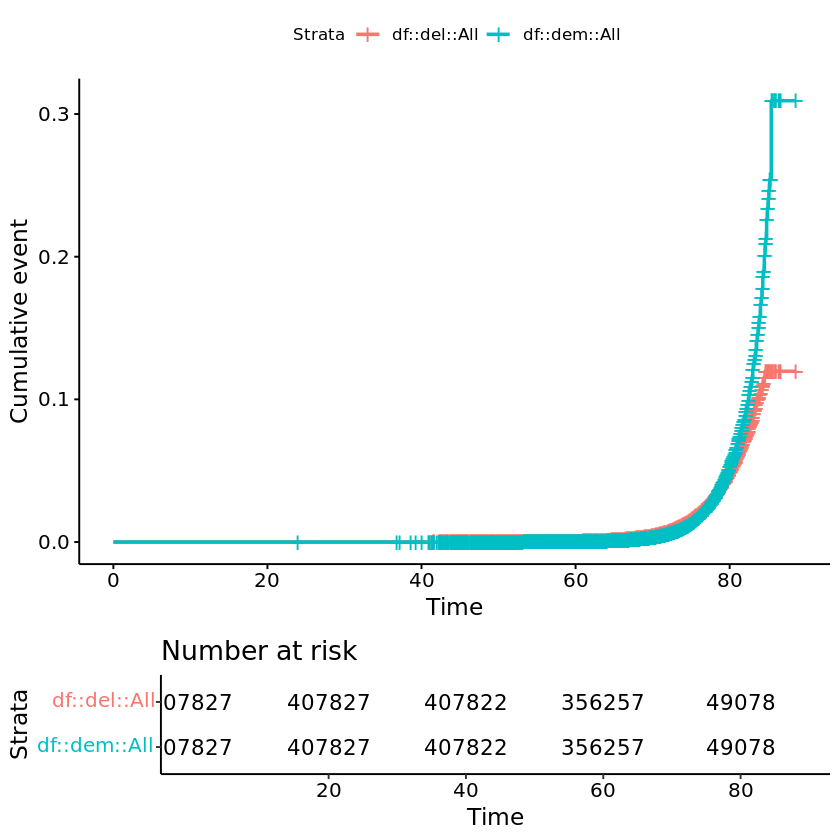

In [64]:
df <- a %>% select(age, delirium, dementia_status) #%>% mutate(age = round(age,0))
formulas <- list(
    del = Surv(age, delirium) ~ 1,
    dem = Surv(age, dementia_status) ~ 1)

fit <- surv_fit(formulas, data=df)
ggsurvplot_combine(fit, data=df, fun='event', risk.table = TRUE)

Plotting outcome "1".


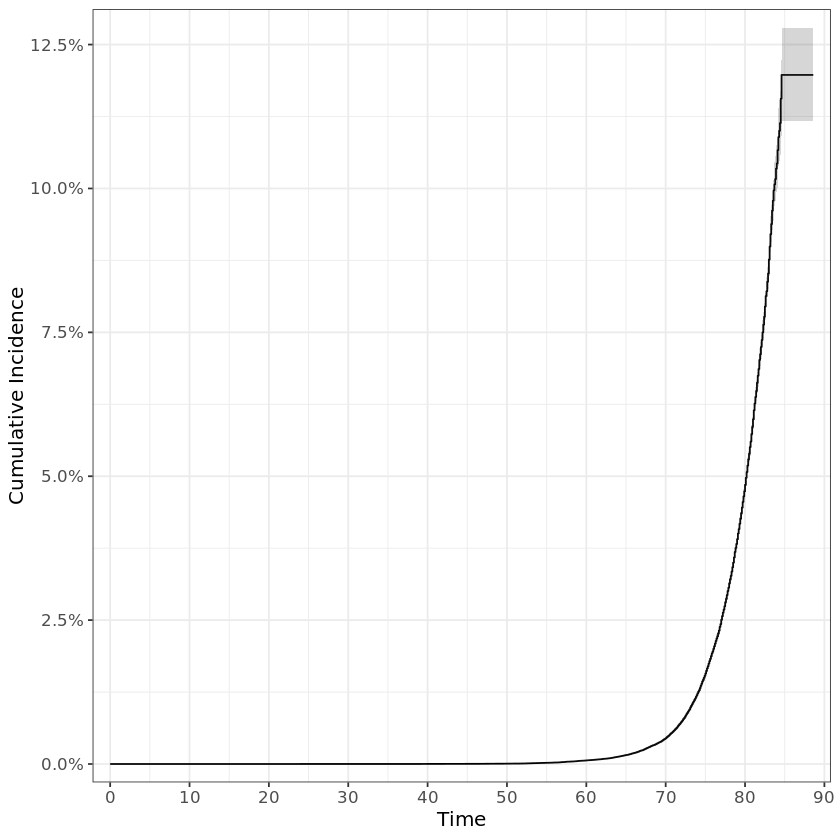

In [66]:
cuminc(Surv(age, as.factor(delirium)) ~ 1, a) %>%
  ggcuminc() +
  add_confidence_interval() +
  scale_ggsurvfit()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


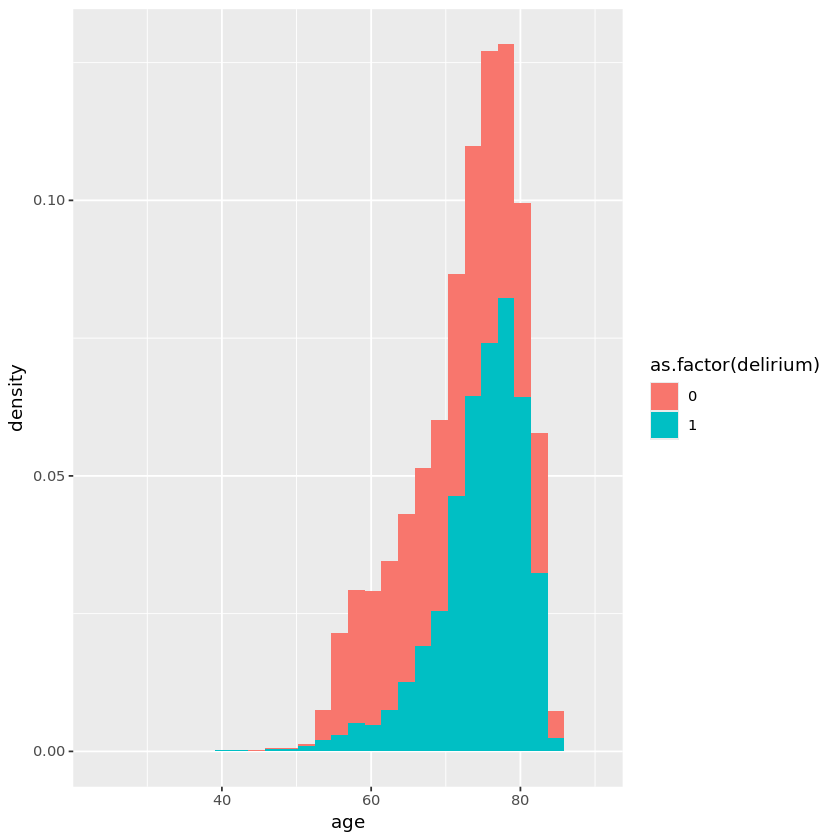

In [89]:
df <-
a %>% 
    select(age, delirium, dementia_status) %>%
    mutate(age = round(age,0)) %>% 
    arrange(age) %>% 
    group_by(age) %>% 
    summarise(n = n(),
              n_delirium = sum(delirium==1),
              n_dementia = sum(dementia_status==1)
             ) %>%
    #filter(age >=50) %>%
    # mutate(pct_delirium = n_delirium / n,
    #        pct_dementia = n_dementia / n)
    mutate(pct_cs_delirium = cumsum(n_delirium) )

#df
# ggplot(data = df, aes(x=age, y=n_delirium)) +
#     geom_line() +
#     geom_point()
ggplot(data = a, aes(x=age, fill=as.factor(delirium))) +
    geom_histogram(aes(y=after_stat(density)))

# df$pct5_delirium <- NA
# df$pct5_dementia <- NA

# for(x in seq(1,nrow(df))){
#     df[x,'pct5_delirium'] <- mean(df[seq(x,x+4),]$pct_delirium)
#     df[x,'pct5_dementia'] <- mean(df[seq(x,x+4),]$pct_dementia)
# }

